# Detection Efficiency Filter Demo

This notebook demonstrates the detection efficiency/fading function filter.

In [2]:
from surveySimPP.modules import PPFootprintFilter as fp
from surveySimPP.modules import PPFadingFunctionFilter as ff

In [3]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
def getSqlData(database,rows_start,nrows):
    """Import dataset from local SQL database
    
    Parameters:
    -----------
    database   ... path to database
    rows_start ... number of row to start
    rows_max   ... number of rows to select
    
    Returns:
    --------
    observations ... pandas dataframe containing observations from JPL database
    """
    con = sql.connect(database)
    observations = pd.read_sql("""SELECT * FROM observations LIMIT """+str(rows_start)+','+str(nrows), con)
    return observations

In [10]:
def randobs(ronsky=3,ra=180,dec=45, n=100000):

    """Create random observations centered on RA, Dec with radius r.
    Random observations are generated correctly only for declinations < dec+r.
    
    Parameters:
    ------------
    ronksy ... on sky radius [deg]
    ra     ... Right Ascension of center [deg]
    dec    ... Declination of center
    
    Returns:
    --------
    raout ... Right Ascension of fake observations
    decout ... Declination of fake observations
    
    """
    # radius of the circle
    # center of the circle (x, y)
    # random angle
    
    rnd1=np.random.rand(n)
    rnd2=np.random.rand(n)
    
    alpha = 2 * np.pi * rnd1
    # random radius
    r = ronsky * np.sqrt(rnd2)
    # calculating coordinates
    raout = r * np.cos(alpha) + ra
    decout = r * np.sin(alpha) + dec
    
    return np.mod(raout+360,360),decout

## Import LSST Opsim database 
This database contains LSST pointings and environmental information such as seeing.


In [11]:
db_path="oneline_v2.0.db"

Select the first exposure of the LSST survey and initialise number of simulated detections.

In [12]:
LSSTdf=getSqlData(db_path,0,1)
rng=np.random.default_rng()
nobs_per_field=1000000

In [13]:
LSSTdf

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,numExposures,airmass,...,moonAz,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz
0,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,r,182.732823,2,1.167313,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656


Some random measurements are then created.

In [22]:
magbins=[]
i=22.0
while(i<=26.0):
    magbins.append(i)
    i=i+0.05

rao,deco=randobs(ronsky=2.5,ra=LSSTdf['fieldRA'][0],dec=LSSTdf['fieldDec'][0],n=nobs_per_field)
dfobs0=pd.DataFrame(np.array([rao,deco]).T,columns=['AstRA(deg)','AstDec(deg)'])
dfobs0['FieldMJD']=LSSTdf['observationStartMJD'][0]
dfobs0['FieldID']=LSSTdf['observationId'][0]

In [16]:
dfobs0

,AstRA(deg),AstDec(deg),FieldMJD,FieldID
0,273.808289,-24.845370,60945.035513,402942
1,273.299018,-24.361108,60945.035513,402942
2,272.754647,-23.065199,60945.035513,402942
3,271.128594,-24.345181,60945.035513,402942
4,273.225995,-24.595487,60945.035513,402942
...,...,...,...,...
999995,275.603006,-25.114380,60945.035513,402942
999996,273.585937,-23.860994,60945.035513,402942
999997,272.331500,-26.223684,60945.035513,402942
999998,272.174724,-23.515713,60945.035513,402942


## Create magnitudes

In [17]:
mags=np.arange(nobs_per_field)
mags=np.random.uniform(22.0,26.0,len(dfobs0))
dfobs = pd.merge(dfobs0, LSSTdf, left_on="FieldID", right_on="observationId", how="left")

# Match keywords
dfobs['observedTrailedSourceMag'] = mags
dfobs['fiveSigmaDepthAtSource']=dfobs['fiveSigmaDepth']


In [18]:
mags

array([23.6371329 , 23.0827614 , 24.61356894, ..., 24.31801887,
       24.57790949, 24.49260826])

In [19]:
dfobs['observedTrailedSourceMag']

0         23.637133
1         23.082761
2         24.613569
3         25.430784
4         24.213592
            ...    
999995    25.592145
999996    24.040818
999997    24.318019
999998    24.577909
999999    24.492608
Name: observedTrailedSourceMag, Length: 1000000, dtype: float64

In [20]:
dfobs

,AstRA(deg),AstDec(deg),FieldMJD,FieldID,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,...,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,observedTrailedSourceMag,fiveSigmaDepthAtSource
0,273.808289,-24.845370,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,23.637133,24.071162
1,273.299018,-24.361108,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,23.082761,24.071162
2,272.754647,-23.065199,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,24.613569,24.071162
3,271.128594,-24.345181,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,25.430784,24.071162
4,273.225995,-24.595487,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,24.213592,24.071162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,275.603006,-25.114380,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,25.592145,24.071162
999996,273.585937,-23.860994,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,24.040818,24.071162
999997,272.331500,-26.223684,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,24.318019,24.071162
999998,272.174724,-23.515713,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,24.577909,24.071162


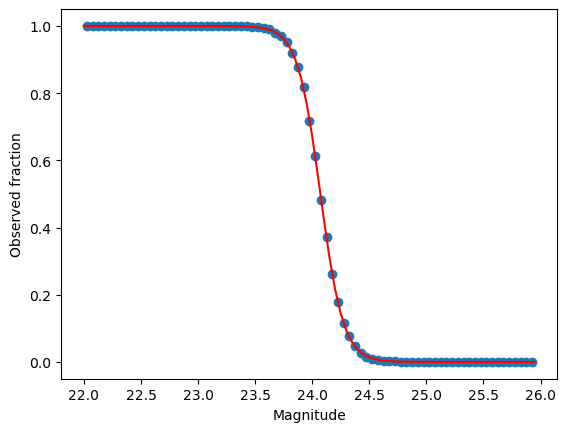

In [21]:
magcounts,magpins=np.histogram(dfobs['observedTrailedSourceMag'],bins=magbins)

reduced_dfobs=ff.PPFadingFunctionFilter(dfobs, 1.0, 0.1, rng)

redmagcounts,redmagbins=np.histogram(reduced_dfobs['observedTrailedSourceMag'],bins=magbins)

res=redmagcounts/magcounts

fiveSigma=dfobs.fiveSigmaDepthAtSource.values[0]

restheor=[]
i=0
while(i<len(magbins)):
    a=1./(1.+np.exp((magbins[i]-fiveSigma)/.1))
    restheor.append(a)
    i=i+1

plt.clf()
plt.scatter(magpins[:-1]+0.025,res)
plt.plot(magbins,restheor, 'r-')
plt.xlabel('Magnitude')
plt.ylabel('Observed fraction')
#plt.savefig('deteff_.jpg', bbox_inches='tight')
plt.show()

